# Import Libraries

<font color="blue">
    <h4>Remove GPU from list of devices, our does not have enough memory.</h4>
</font>

In [1]:
import os
os.environ[ 'CUDA_VISIBLE_DEVICES' ] = '-1'

<font color="blue">
    <h4>Imports</h4>
</font>

In [2]:
import matplotlib.pyplot as plt
import numpy      as np
import pandas     as pd
import tensorflow as tf

from sklearn import metrics
from sklearn import utils

In [3]:
# PRINT F1-SCORES WITH 2 DIGITS
pd.set_option('display.float_format', lambda x: '%.2f' % x)

<font color="blue">
    <h4>Confirm No GPU found</h4>
</font>

In [4]:
print( tf.config.list_physical_devices('GPU') )

[]


# Restore Point

In [5]:
# NUMERICAL FEATURES
X_train = pd.read_pickle( 'data/X_train.pkl' )
X_val   = pd.read_pickle( 'data/X_val.pkl' )
X_test  = pd.read_pickle( 'data/X_test.pkl' )

# TARGET
y_train = pd.read_pickle( 'data/y_train.pkl' )
y_val   = pd.read_pickle( 'data/y_val.pkl' )
y_test  = pd.read_pickle( 'data/y_test.pkl' )

In [6]:
# BAGS OF WORDS
counts = []
counts.append( pd.read_pickle( 'data/counts_train.pkl' ) )
counts.append( pd.read_pickle( 'data/counts_val.pkl' ) )
counts.append( pd.read_pickle( 'data/counts_test.pkl' ) )

In [7]:
# WORD LEVEL TD-IDF
word_tfidf = []
word_tfidf.append( pd.read_pickle( 'data/word_train.pkl' ) )
word_tfidf.append( pd.read_pickle( 'data/word_val.pkl' ) )
word_tfidf.append( pd.read_pickle( 'data/word_test.pkl' ) )

In [8]:
# N-GRAM LEVEL TD-IDF
ngram_tfidf = []
ngram_tfidf.append( pd.read_pickle( 'data/ngram_train.pkl' ) )
ngram_tfidf.append( pd.read_pickle( 'data/ngram_val.pkl' ) )
ngram_tfidf.append( pd.read_pickle( 'data/ngram_test.pkl' ) )

In [9]:
# CHARACTER LEVEL TD-IDF
char_tfidf = []
char_tfidf.append( pd.read_pickle( 'data/char_train.pkl' ) )
char_tfidf.append( pd.read_pickle( 'data/char_val.pkl' ) )
char_tfidf.append( pd.read_pickle( 'data/char_test.pkl' ) )

In [10]:
# EMBEDDINGS
embeddings_df = []
embeddings_df.append( pd.read_pickle( 'data/embedding_train.pkl' ) )
embeddings_df.append( pd.read_pickle( 'data/embedding_val.pkl' ) )
embeddings_df.append( pd.read_pickle( 'data/embedding_test.pkl' ) )

In [11]:
# CONVERT EMBEDDING DATAFRAME AS NUMPY ARRAYS
embeddings = []
col_text = [ 'summary', 'impact', 'description', 'ped' ]

for df in embeddings_df:
    
    d = {}
    
    for c in col_text:
        
        d[ c ] = np.array( [ val for val in df[ c ].values ] )
        
    embeddings.append( d )

del embeddings_df

# Modeling: Utilities

<font color="blue">
    <h4>Class Weights</h4>
    <li>Helps with target imbalance</li>
</font>

In [12]:
weights = utils.class_weight.compute_class_weight( class_weight = 'balanced',
                                                   classes = np.unique( y_train ),
                                                    y = y_train )

<font color="blue">
    <h4>Decaying learning schedule</h4>
    <li>Many models train better if you gradually reduce the learning rate during training</li>
</font>

In [13]:
def lr_schedule( batch_size ):

    steps_per_epoch = len( X_train ) / batch_size

    return tf.keras.optimizers.schedules.InverseTimeDecay( initial_learning_rate = 0.001,
                                                           decay_steps = steps_per_epoch * 5,
                                                           decay_rate = 1,
                                                           staircase = False )
# TO VISUALISE LR SCHEDULE
#step = np.linspace( 0, 2000 )
#lr = lr_schedule( step )
#plt.figure( figsize = (8,6) )
#plt.plot( step / STEPS_PER_EPOCH, lr )
#plt.ylim( [ 0, max( plt.ylim() ) ])
#plt.xlabel( 'Epoch' )
#_ = plt.ylabel( 'Learning Rate' )

<font color="blue">
    <h4>Optimizer</h4>
    <li>Use SGD because it is faster, did not observe improvements with others such as Adam, Nadam.</li>
    <li>Use a decaying learning rate</li>
</font>

In [14]:
def optimizer( schedule ):
    
    return tf.keras.optimizers.SGD( learning_rate = schedule )

<font color="blue">
    <h4>Visualize Learning Process</h4>
</font>

In [15]:
def plot_history( history ):
    epoch_list = list( range( 1, len( history.history[ 'loss' ] ) + 1 ) )

    plt.suptitle( 'Neural Network Performance' )

    plt.plot( epoch_list, history.history[ 'loss' ], epoch_list, history.history[ 'val_loss' ] )
    plt.legend( ( 'Training Loss', 'Validation Loss' ) )
    plt.grid()

    plt.show()

<font color="blue">
    <h4>Complile, Fit and Evaluate Model</h4>
</font>

In [16]:
# COMMON MODEL EVALUATION METHOD
def train_model( model, name, train_X, train_y, val_X, val_y, test_X, test_y, results,
                 batch_size = 128, epochs = 10, verbose = 0 ):
    
    # COMPILE MODEL
    

    lr_schedule( batch_size = batch_size )

    model.compile( optimizer = optimizer( lr_schedule( batch_size = batch_size ) ),
                   loss = 'binary_crossentropy' )

    # FIT WITH TRAIN DATA, USE VALIDATION DATA FOR CROSS-VALIDATION
    history = model.fit( x = train_X,
                         y = train_y,
                         batch_size = batch_size,
                         epochs = epochs,
                         verbose = verbose,
                         validation_data = ( val_X, val_y ),
                         class_weight = { i: w for i, w in enumerate( weights ) } )
    
    # SAVE TRAINING SCORE
    y_proba = model.predict( x = train_X,
                             batch_size = batch_size,
                             verbose = 0 )
    y_preds = np.where( y_proba > 0.5, 1, 0 )
    results[ 'Model'      ].append( name )
    results[ 'Training'   ].append( metrics.f1_score( y_preds, train_y ) )
    
    # SAVE VALIDATION SCORE
    y_proba = model.predict( x = val_X,
                             batch_size = batch_size,
                             verbose = 0 )
    y_preds = np.where( y_proba > 0.5, 1, 0 )
    results[ 'Validation'   ].append( metrics.f1_score( y_preds, val_y ) )
    
    # SAVE TESTING SCORE
    y_proba = model.predict( x = test_X,
                             batch_size = batch_size,
                             verbose = 0 )
    y_preds = np.where( y_proba > 0.5, 1, 0 )
    results[ 'Testing'   ].append( metrics.f1_score( y_preds, test_y ) )
    
    return history

# Modeling: Flat Inputs
- Bags of Words and TF-IDF

In [17]:
def make1D():
    
    model = tf.keras.Sequential()
    
    model.add( tf.keras.layers.Normalization() )
    
    model.add( tf.keras.layers.Dense( units = 500,
                                      activation = 'relu' ) ) # kernel_regularizer = tf.keras.regularizers.L2( l2 = 0.04 )
    
    #model.add( tf.keras.layers.Dense( units = 500,
    #                                  activation = 'relu' ) )
    
    model.add( tf.keras.layers.Dense( units = 1,
                                      activation = 'sigmoid' ) )
    
    return model

In [18]:
%%time

# ALL RESULTS DICTIONARY
results = { 'Model':      [],
            'Training':   [],
            'Validation': [],
            'Testing' :   [] }

# WITH ON BAGS OF WORDS
train_model( model = make1D(),
             name = 'NN 1D w/Bags Of Words',
             train_X = pd.concat( objs = [ X_train, counts[0] ], axis = 1 ),
             train_y = y_train,
             val_X = pd.concat( objs = [ X_val, counts[1] ], axis = 1 ),
             val_y = y_val,
             test_X = pd.concat( objs = [ X_test, counts[2] ], axis = 1 ),
             test_y = y_test,
             results = results )
print( '.' )

# WITH WORD LEVEL TF-IDF
train_model( model = make1D(),
             name = 'NN 1D w/Word TF-IDF',
             train_X = pd.concat( objs = [ X_train, word_tfidf[0] ], axis = 1 ),
             train_y = y_train,
             val_X = pd.concat( objs = [ X_val, word_tfidf[1] ], axis = 1 ),
             val_y = y_val,
             test_X = pd.concat( objs = [ X_test, word_tfidf[2] ], axis = 1 ),
             test_y = y_test,
             results = results )
print( '.' )

# WITH N-GRAM LEVEL TF-IDF
train_model( model = make1D(),
             name = 'NN 1D w/N-Gram TF-IDF',
             train_X = pd.concat( objs = [ X_train, ngram_tfidf[0] ], axis = 1 ),
             train_y = y_train,
             val_X = pd.concat( objs = [ X_val, ngram_tfidf[1] ], axis = 1 ),
             val_y = y_val,
             test_X = pd.concat( objs = [ X_test, ngram_tfidf[2] ], axis = 1 ),
             test_y = y_test,
             results = results )
print( '.' )

# WITH CHARACTER LEVEL TF-IDF
train_model( model = make1D(),
             name = 'NN 1D w/Char TF-IDF',
             train_X = pd.concat( objs = [ X_train, char_tfidf[0] ], axis = 1 ),
             train_y = y_train,
             val_X = pd.concat( objs = [ X_val, char_tfidf[1] ], axis = 1 ),
             val_y = y_val,
             test_X = pd.concat( objs = [ X_test, char_tfidf[2] ], axis = 1 ),
             test_y = y_test,
             results = results )
print( '.' )
    
pd.DataFrame( results )

.
.
.
.
CPU times: total: 50.9 s
Wall time: 8.34 s


,Model,Training,Validation,Testing
0,NN 1D w/Bags Of Words,0.15,0.05,0.07
1,NN 1D w/Word TF-IDF,0.22,0.22,0.22
2,NN 1D w/N-Gram TF-IDF,0.24,0.15,0.17
3,NN 1D w/Char TF-IDF,0.17,0.09,0.07


# Modeling: 2D Embeddings Inputs (Flattened)

In [19]:
def make_flatten():
    
    # NODES FOR TEXT FEATURES
    txt_model = []
    for c in col_text:
        
        txt_input = tf.keras.layers.Input( shape = embeddings[0][c][0].shape )
        
        txt_flatten = tf.keras.layers.Flatten()( txt_input )
    
        txt_model.append( tf.keras.Model( inputs  = txt_input,
                                          outputs = txt_flatten ) )
        
    # NODES FOR NUMERIC FEATURES
    num_input = tf.keras.layers.Input( shape = ( len( X_train.columns ), ) )

    # MERGE
    l_merge = tf.keras.layers.concatenate( [ txt_model[0].output,
                                             txt_model[1].output,
                                             txt_model[2].output,
                                             txt_model[3].output,
                                             num_input ] )
    
    l_norm = tf.keras.layers.Normalization()( l_merge )
    
    l_dense = tf.keras.layers.Dense( units = 1000,
                                    activation = 'relu' )( l_norm )
    
    l_dense = tf.keras.layers.Dense( units = 1000,
                                    activation = 'relu' )( l_merge )
    
    l_output = tf.keras.layers.Dense( units = 1,
                                      activation = 'sigmoid' )( l_dense )
        
    return tf.keras.Model( inputs = [ txt_model[0].input,
                                      txt_model[1].input,
                                      txt_model[2].input,
                                      txt_model[3].input,
                                      num_input ],
                           outputs = [ l_output ] )

In [20]:
%%time

# ALL RESULTS DICTIONARY
results = { 'Model':      [],
            'Training':   [],
            'Validation': [],
            'Testing' :   [] }

# WITH FLATTENED EMBEDDINGS
history = train_model( model = make_flatten(),
                       name = 'NN 1D w/Embeddings',
                       train_X = [ embeddings[0]['summary'],
                                   embeddings[0]['impact'],
                                   embeddings[0]['description'],
                                   embeddings[0]['ped'],
                                   X_train ],
                       train_y = y_train,
                       val_X = [ embeddings[1]['summary'],
                                 embeddings[1]['impact'],
                                 embeddings[1]['description'],
                                 embeddings[1]['ped'],
                                 X_val ],
                       val_y = y_val,
                       test_X = [ embeddings[2]['summary'],
                                  embeddings[2]['impact'],
                                  embeddings[2]['description'],
                                  embeddings[2]['ped'],
                                  X_test ],
                       test_y = y_test,
                       results = results )

CPU times: total: 15 s
Wall time: 2.03 s


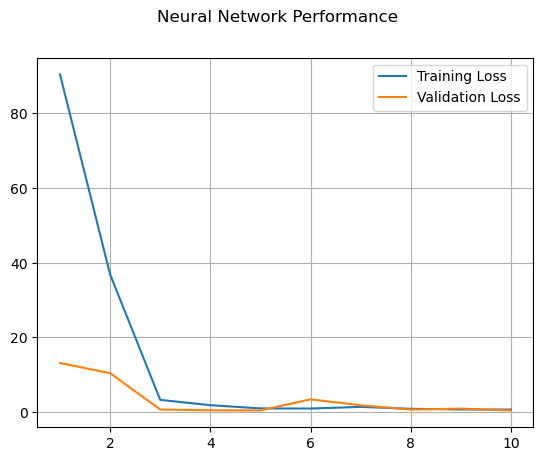

In [21]:
plot_history( history )

In [22]:
pd.DataFrame( results )

,Model,Training,Validation,Testing
0,NN 1D w/Embeddings,0.15,0.03,0.03


# Modeling: 2D Embeddings Inputs (CNN)

In [23]:
def make_cnn():
    
    # NODES FOR TEXT FEATURES
    txt_model = []
    for c in col_text:
        
        txt_input = tf.keras.layers.Input( shape = (embeddings[0][c][0].shape[0], embeddings[0][c][0].shape[1], 1) )
        
        txt_cnn = tf.keras.layers.Conv2D( filters = 32,
                                          kernel_size = ( 3, 3 ),
                                          padding = 'same',
                                          activation = 'relu' )( txt_input )
        
        txt_pool = tf.keras.layers.MaxPooling2D()( txt_cnn )
        
        txt_flatten = tf.keras.layers.Flatten()( txt_pool )
    
        txt_model.append( tf.keras.Model( inputs  = txt_input,
                                          outputs = txt_flatten ) )
        
    # NODES FOR NUMERIC FEATURES
    num_input = tf.keras.layers.Input( shape = ( len( X_train.columns ), ) )

    # MERGE
    l_merge = tf.keras.layers.concatenate( [ txt_model[0].output,
                                             txt_model[1].output,
                                             txt_model[2].output,
                                             txt_model[3].output,
                                             num_input ] )
    
    l_norm = tf.keras.layers.Normalization()( l_merge )
    
    l_dense = tf.keras.layers.Dense( units = 1000,
                                    activation = 'relu' )( l_norm )
    
    l_output = tf.keras.layers.Dense( units = 1,
                                      activation = 'sigmoid' )( l_dense )
        
    return tf.keras.Model( inputs = [ txt_model[0].input,
                                      txt_model[1].input,
                                      txt_model[2].input,
                                      txt_model[3].input,
                                      num_input ],
                           outputs = [ l_output ] )

In [24]:
m = make_cnn()
m.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 2, 384, 1)]  0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 5, 384, 1)]  0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 18, 384, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_9 (InputLayer)           [(None, 5, 384, 1)]  0           []                         

In [25]:
%%time

# ALL RESULTS DICTIONARY
results = { 'Model':      [],
            'Training':   [],
            'Validation': [],
            'Testing' :   [] }

# WITH FLATTENED EMBEDDINGS
history = train_model( model = m,
                       name = 'CNN w/Embeddings',
                       train_X = [ embeddings[0]['summary'],
                                   embeddings[0]['impact'],
                                   embeddings[0]['description'],
                                   embeddings[0]['ped'],
                                   X_train ],
                       train_y = y_train,
                       val_X = [ embeddings[1]['summary'],
                                 embeddings[1]['impact'],
                                 embeddings[1]['description'],
                                 embeddings[1]['ped'],
                                 X_val ],
                       val_y = y_val,
                       test_X = [ embeddings[2]['summary'],
                                  embeddings[2]['impact'],
                                  embeddings[2]['description'],
                                  embeddings[2]['ped'],
                                  X_test ],
                       test_y = y_test,
                       results = results,
                       batch_size = 128,
                       epochs = 10,
                       verbose = 1 )

Epoch 1/10
3/3 [==============================] - 2s 483ms/step - loss: 97.0702 - val_loss: 0.4664
Epoch 2/10
3/3 [==============================] - 1s 464ms/step - loss: 0.7207 - val_loss: 1.1109
Epoch 3/10
3/3 [==============================] - 1s 450ms/step - loss: 0.7536 - val_loss: 0.8093
Epoch 4/10
3/3 [==============================] - 1s 475ms/step - loss: 0.6992 - val_loss: 0.7211
Epoch 5/10
3/3 [==============================] - 1s 433ms/step - loss: 0.6810 - val_loss: 0.7603
Epoch 6/10
3/3 [==============================] - 1s 453ms/step - loss: 0.6827 - val_loss: 0.6979
Epoch 7/10
3/3 [==============================] - 1s 450ms/step - loss: 0.6788 - val_loss: 0.6286
Epoch 8/10
3/3 [==============================] - 1s 462ms/step - loss: 0.6798 - val_loss: 0.7954
Epoch 9/10
3/3 [==============================] - 1s 448ms/step - loss: 0.6857 - val_loss: 0.7383
Epoch 10/10
3/3 [==============================] - 1s 438ms/step - loss: 0.6784 - val_loss: 0.7850
CPU times: total: 

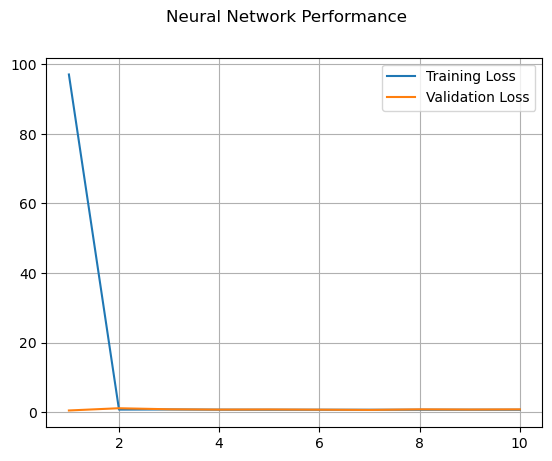

In [26]:
plot_history( history )

In [27]:
pd.DataFrame( results )

,Model,Training,Validation,Testing
0,CNN w/Embeddings,0.24,0.21,0.21


# Modeling: 2D Embeddings Inputs (RNN)

In [60]:
def make_rnn():
    
    # NODES FOR TEXT FEATURES
    txt_model = []
    for c in col_text:
        
        txt_input = tf.keras.layers.Input( shape = embeddings[0][c][0].shape )
        
        txt_lstm1 = tf.keras.layers.LSTM( units = 200,
                                          return_sequences = False )( txt_input )
        
        #txt_lstm2 = tf.keras.layers.LSTM( units = 200,
        #                                  return_sequences = False )( txt_lstm1 )
    
        txt_model.append( tf.keras.Model( inputs  = txt_input,
                                          outputs = txt_lstm1 ) )
        
    # NODES FOR NUMERIC FEATURES
    num_input = tf.keras.layers.Input( shape = ( len( X_train.columns ), ) )

    # MERGE
    l_merge = tf.keras.layers.concatenate( [ txt_model[0].output,
                                             txt_model[1].output,
                                             txt_model[2].output,
                                             txt_model[3].output,
                                             num_input ] )
    
    l_norm = tf.keras.layers.Normalization()( l_merge )
    
    l_dense = tf.keras.layers.Dense( units = 1000,
                                    activation = 'relu' )( l_norm )
    
    l_output = tf.keras.layers.Dense( units = 1,
                                      activation = 'sigmoid' )( l_dense )
        
    return tf.keras.Model( inputs = [ txt_model[0].input,
                                      txt_model[1].input,
                                      txt_model[2].input,
                                      txt_model[3].input,
                                      num_input ],
                           outputs = [ l_output ] )

In [61]:
m = make_rnn()
m.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 2, 384)]     0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 5, 384)]     0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 18, 384)]    0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None, 5, 384)]     0           []                               
                                                                                           

In [65]:
%%time

# ALL RESULTS DICTIONARY
results = { 'Model':      [],
            'Training':   [],
            'Validation': [],
            'Testing' :   [] }

# WITH FLATTENED EMBEDDINGS
history = train_model( model = m,
                       name = 'RNN w/Embeddings',
                       train_X = [ embeddings[0]['summary'],
                                   embeddings[0]['impact'],
                                   embeddings[0]['description'],
                                   embeddings[0]['ped'],
                                   X_train ],
                       train_y = y_train,
                       val_X = [ embeddings[1]['summary'],
                                 embeddings[1]['impact'],
                                 embeddings[1]['description'],
                                 embeddings[1]['ped'],
                                 X_val ],
                       val_y = y_val,
                       test_X = [ embeddings[2]['summary'],
                                  embeddings[2]['impact'],
                                  embeddings[2]['description'],
                                  embeddings[2]['ped'],
                                  X_test ],
                       test_y = y_test,
                       results = results,
                       batch_size = 512,
                       epochs = 20,
                       verbose = 1 )

Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 3.4239 - val_loss: 96.8682
Epoch 2/20
1/1 [==============================] - 0s 369ms/step - loss: 58.6338 - val_loss: 14.4435
Epoch 3/20
1/1 [==============================] - 0s 370ms/step - loss: 8.8629 - val_loss: 3.3680
Epoch 4/20
1/1 [==============================] - 0s 355ms/step - loss: 13.6636 - val_loss: 4.8660
Epoch 5/20
1/1 [==============================] - 0s 354ms/step - loss: 3.0848 - val_loss: 2.3716
Epoch 6/20
1/1 [==============================] - 0s 380ms/step - loss: 9.4292 - val_loss: 2.0633
Epoch 7/20
1/1 [==============================] - 0s 370ms/step - loss: 1.4324 - val_loss: 1.3841
Epoch 8/20
1/1 [==============================] - 0s 360ms/step - loss: 5.3047 - val_loss: 3.7131
Epoch 9/20
1/1 [==============================] - 0s 379ms/step - loss: 2.3846 - val_loss: 1.1449
Epoch 10/20
1/1 [==============================] - 0s 370ms/step - loss: 4.2662 - val_loss: 2.8316
Epoch 11/20
1/1 [=

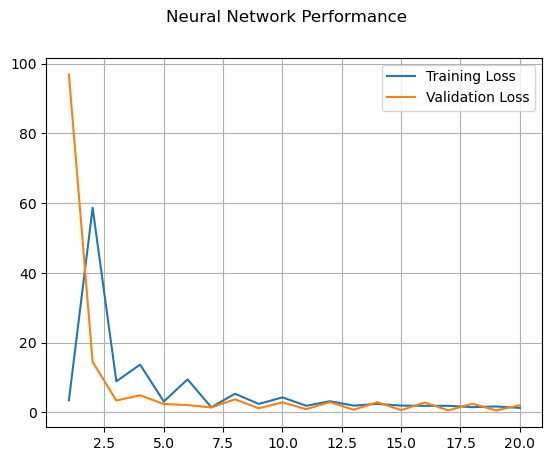

In [66]:
plot_history( history )

In [67]:
pd.DataFrame( results )

,Model,Training,Validation,Testing
0,RNN w/Embeddings,0.24,0.22,0.22
